In [0]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import scipy as stats


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# filepath = "/content/drive/My Drive/Multi/"
# fraud = pd.read_csv(filepath + "Fraud_Data.csv")
# ip = pd.read_csv(filepath + "IpAddress_to_Country.csv")


In [0]:
# fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
user_id           151112 non-null int64
signup_time       151112 non-null object
purchase_time     151112 non-null object
purchase_value    151112 non-null int64
device_id         151112 non-null object
source            151112 non-null object
browser           151112 non-null object
sex               151112 non-null object
age               151112 non-null int64
ip_address        151112 non-null float64
class             151112 non-null int64
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


In [0]:
# ip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
lower_bound_ip_address    138846 non-null float64
upper_bound_ip_address    138846 non-null int64
country                   138846 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [0]:

# countries = []
# for i in range(len(fraud)):
#     ip_address = fraud.loc[i, 'ip_address']
#     tmep = ip[(ip['lower_bound_ip_address'] <= ip_address) &
#                           (ip['upper_bound_ip_address'] >= ip_address)]
#     if len(tmep) == 1:
#         countries.append(tmep['country'].values[0])
#     else:
#         countries.append('Unknown')
        
# fraud['country'] = countries

# fraud.head()

In [0]:
# merge = fraud.to_csv (filepath+"fraud_merge_country.csv", index = None, header=True)

In [3]:
filepath = "/content/drive/My Drive/Multi/"
fraud_merge = pd.read_csv(filepath +"fraud_merge_country.csv")
fraud_merge.head()


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Unknown
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


## Exploratory analysis & Feature Engineering

In [0]:
for col in ['signup_time','purchase_time']:
  fraud_merge[col] = pd.to_datetime(fraud_merge[col])

We can notice that dataset includes records in year 2015.

In [5]:
def from_to(col,df):
  print(col,":")
  print('From:%s' % df[col].min())
  print('To:%s' % df[col].max())


from_to('purchase_time',fraud_merge)
from_to('signup_time',fraud_merge)

purchase_time :
From:2015-01-01 00:00:44
To:2015-12-16 02:56:05
signup_time :
From:2015-01-01 00:00:42
To:2015-08-18 04:40:29


Deal with time variables:
* 1.group the time as day, week, month
* 2.create a new variable as time difference between signup and purchase


In [0]:
def time_convert(col):
  fraud_merge[col[:-5]+ "_" + 'month'] = fraud_merge[col].dt.month
  fraud_merge[col[:-5]+ "_" + 'weekofyear'] = fraud_merge[col].dt.weekofyear
  fraud_merge[col[:-5]+ "_" + 'weekday'] = fraud_merge[col].dt.weekday

for col in ['signup_time','purchase_time']:
  time_convert(col)

In [0]:
fraud_merge['signTOpurchase'] = (fraud_merge['purchase_time']-fraud_merge['signup_time']).dt.total_seconds()

In [0]:
timelist = [ 'signup_time','purchase_time', 'signup_month', 'signup_weekofyear', 
            'signup_weekday', 'purchase_month', 'purchase_weekofyear', 'purchase_weekday']

numlist = ['purchase_value', 'age','signTOpurchase']

catlist = [col for col in fraud_merge.columns if col not in (timelist+numlist)]


In [9]:
fraud_merge[numlist].describe()

,purchase_value,age,signTOpurchase
count,151112.000000,151112.000000,1.511120e+05
mean,36.935372,33.140704,4.932029e+06
std,18.322762,8.617733,3.126263e+06
min,9.000000,18.000000,1.000000e+00
25%,22.000000,27.000000,2.186754e+06
50%,35.000000,33.000000,4.926346e+06
75%,49.000000,39.000000,7.644525e+06
max,154.000000,76.000000,1.036797e+07


## Outliers Check
* it seems all these variables are not hugely affected by outliers, also we want it to be sensitive when detecting fraud, extreme values will be important to, so we will not delete outliers here.

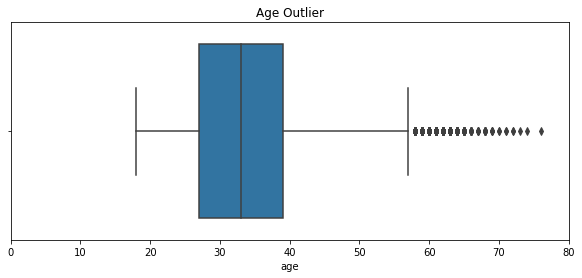

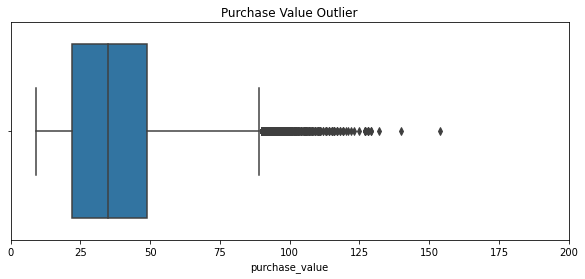

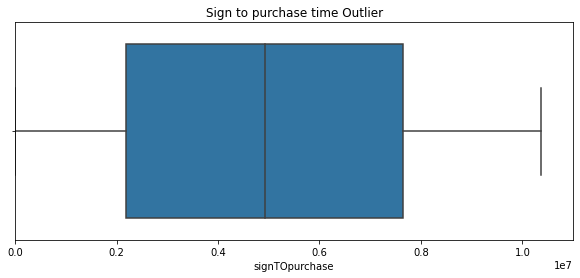

In [10]:

plt.figure(figsize=(10,4))
plt.xlim(0, 80)
plt.title("Age Outlier")
sns.boxplot(x=fraud_merge['age'])


plt.figure(figsize=(10,4))
plt.xlim(0, 200)
plt.title("Purchase Value Outlier")
sns.boxplot(x=fraud_merge['purchase_value'])



plt.figure(figsize=(10,4))
plt.title("Sign to purchase time Outlier")
plt.xlim(0, 1.1e+07)
sns.boxplot(x=fraud_merge['signTOpurchase'])



#### we can find devices and ip are shared
* n of user id != n of device
* n of user id != n of ip_address

#### Thus, we can create new features including the times they are shared, which can be suspicious if more is shared

#### we can notice that we have in total 182 countries, the less visit from a country can be more suspicious

In [11]:
fraud_merge[catlist].nunique() 

user_id       151112
device_id     137956
source             3
browser            5
sex                2
ip_address    143512
class              2
country          182
dtype: int64

In [0]:
# deal with shared devices and ip
device_shared = fraud_merge.device_id.value_counts()
ip_shared = fraud_merge.ip_address.value_counts()
fraud_merge ['device_shared'] = fraud_merge.device_id.map(device_shared)
fraud_merge['ip_shared']= fraud_merge.ip_address.map(ip_shared)

# deal with country
country_shared = fraud_merge.country.value_counts()
fraud_merge['country_shared'] = fraud_merge.country.map(country_shared)


In [0]:
for col in ['device_shared','ip_shared','country_shared']:
  numlist.append(col)

In [14]:
for col in ['source', 'browser', 'sex', 'class']:
    print(fraud_merge[col].unique())
    print(fraud_merge[col].value_counts())

['SEO' 'Ads' 'Direct']
SEO       60615
Ads       59881
Direct    30616
Name: source, dtype: int64
['Chrome' 'Opera' 'Safari' 'IE' 'FireFox']
Chrome     61432
IE         36727
Safari     24667
FireFox    24610
Opera       3676
Name: browser, dtype: int64
['M' 'F']
M    88293
F    62819
Name: sex, dtype: int64
[0 1]
0    136961
1     14151
Name: class, dtype: int64


### Check if dataset is balanced

* dataset is not balanced, we can consider oversample to rebalance it

In [15]:
print('Fraud rate is {:.3f}%'.format(np.mean(fraud_merge['class'])*100))

Fraud rate is 9.365%


### Regular distribution without bootstrap


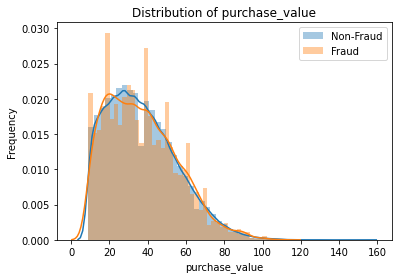

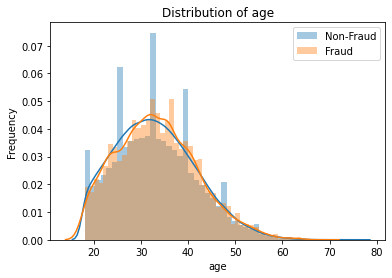

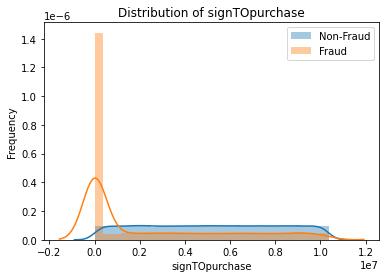

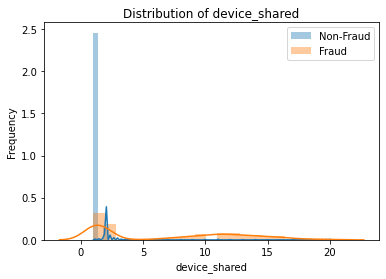

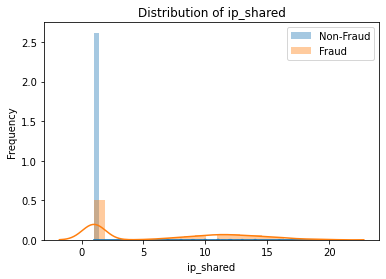

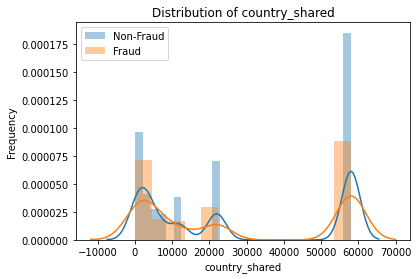

In [16]:
fraud = fraud_merge[fraud_merge['class'] == 1].copy()
non_fraud = fraud_merge[fraud_merge['class'] == 0].copy()
for col in numlist:
    # Plot the samples
    sns.distplot(non_fraud[col], label='Non-Fraud')
    sns.distplot(fraud[col], label='Fraud')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title('Distribution of {}'.format(col))
    plt.legend()
    plt.show()

Bootstrap distribution

In [0]:
# Define a function for bootstrapping
def bootstrap_mean(cat, num):
    non_fraud_bootstrap = np.empty(num)
    fraud_bootstrap = np.empty(num)

    for i in range(num):
        non_fraud_bootstrap[i] = np.mean(np.random.choice(non_fraud[cat], len(non_fraud)))
        fraud_bootstrap[i] = np.mean(np.random.choice(fraud[cat], len(fraud)))
        
    return non_fraud_bootstrap, fraud_bootstrap

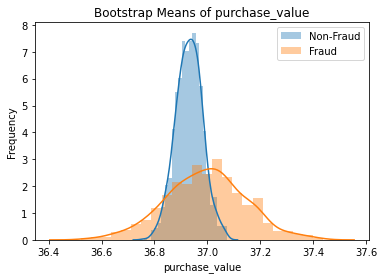

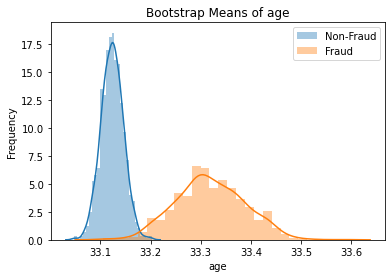

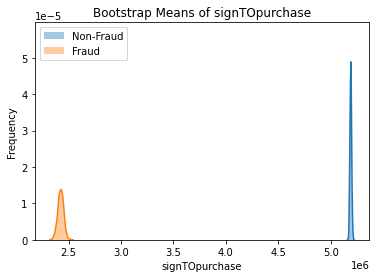

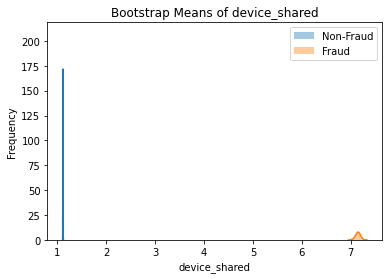

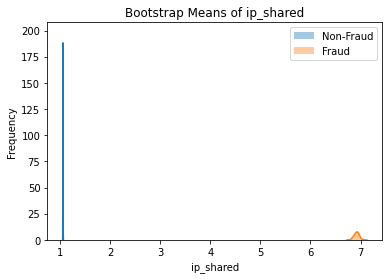

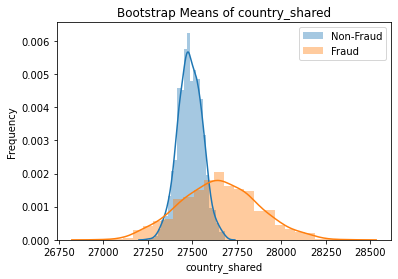

In [18]:
for col in numlist:
    
    # Define 1000 bootstrap samples for each category
    non_fraud_repl, fraud_repl = bootstrap_mean(col, 1000)

    # Plot the samples
    sns.distplot(non_fraud_repl, label='Non-Fraud')
    sns.distplot(fraud_repl, label='Fraud')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title('Bootstrap Means of {}'.format(col))
    plt.legend()
    plt.show()


## Key Findings for numerical variables:
* Sign to purchase time: sign to purchase time seems to be a strong impact variable since it appears that fraud tends to happen when purchase is made within 24 hours of the sign up.

* Age: It seems that fraudulent activities have a higher frequency around age 31 - 33

* purchase value: It seems that purchase value dose not impact it so much.

* IP shared: IP shared more times, the more likely the activity is fruadulent (near 7 is high risky)

* Device shared: Device shared more times, the more likely it is fruadulent activity(near 7 is high risky).

* Country shared(visited times from a country): The less visit from a country, the more likely purchase from this country is fruad.



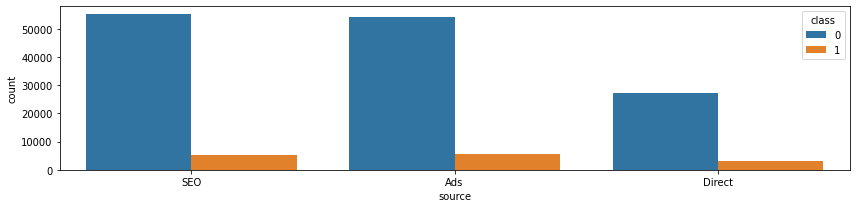

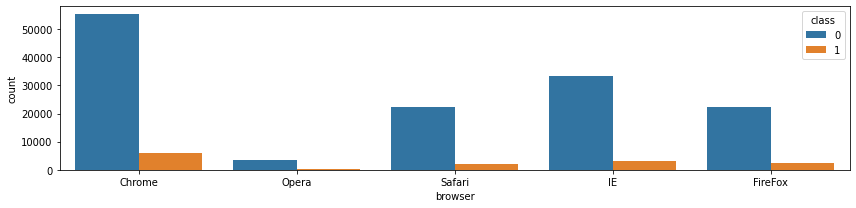

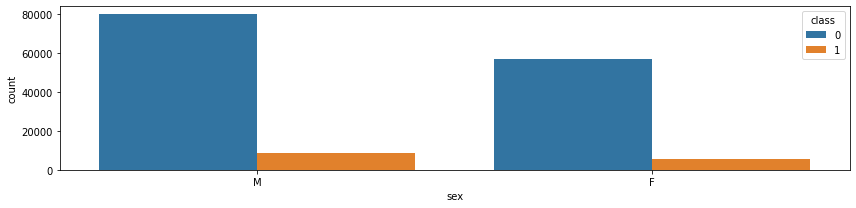

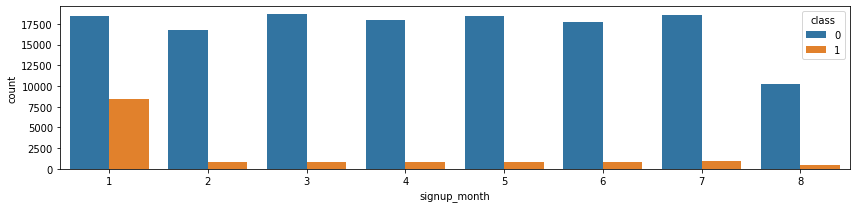

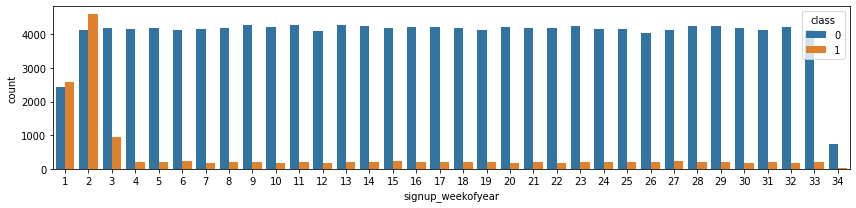

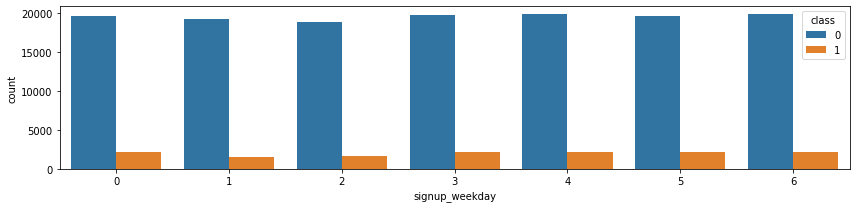

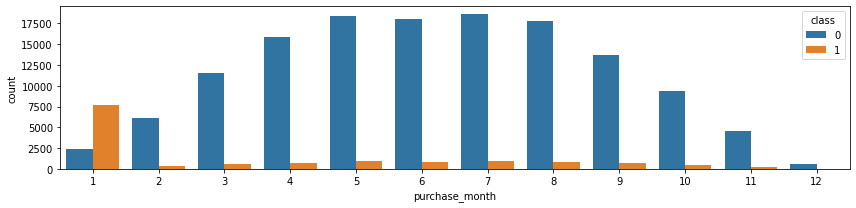

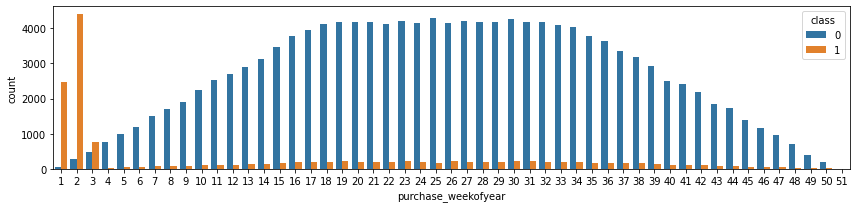

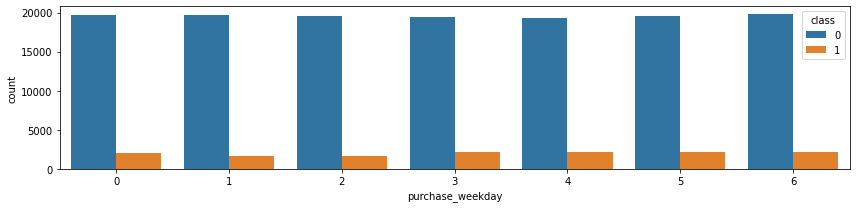

In [19]:
timelist_1 = [i for i in timelist if i not in ['signup_time','purchase_time']]


for col in ['source', 'browser', 'sex'] + timelist_1:
    plt.figure(figsize=(12,3))
    sns.countplot(x=col, hue='class', data=fraud_merge)
    plt.tight_layout()


Key Findings for Categorical variables:
* SEO and Ads have higher frequency of fraud.
* It seems that fraudulent activities occur most during January(The first 3 weeks and espically high in Feb), we keep weekofyear as our time varaible while deleting day of year and month.
* Chrome has the most fraud activity

In [0]:
# Import LabelEncoder
from sklearn.preprocessing import LabelEncoder

# Import train_test_split
from sklearn.model_selection import train_test_split

# Import roc_auc_score, roc_curve, and auc
from sklearn.metrics import roc_auc_score, roc_curve, auc

Create dummny variables based on the categorical variables.

In [0]:
use_col = ['class','source','browser','sex','signup_weekofyear','purchase_weekofyear',
            'age','signTOpurchase','device_shared', 'ip_shared',	'country_shared']

use_cat = ['source','browser','sex']
df = fraud_merge[use_col].copy()

# dum_col = [col for col in use_col if df[col].dtype == object]
# for col in dum_col:
#    df[col] = LabelEncoder().fit_transform(df[col])

In [0]:
X=df.drop(['class'],axis=1)
y=df['class']

for col in use_cat:
  dummies = pd.get_dummies(X[col]).rename(columns=lambda x:col+str(x))
  X=X.join(dummies)
  del X[col]

Balance the dataset

In [59]:
from imblearn.over_sampling import SMOTE
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=0)

os = SMOTE(sampling_strategy = 0.5, random_state=0)
columns = X_train.columns

os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['class'])
#Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Proportion of non-fraud data in oversampled data is ",len(os_data_y[os_data_y['class']==0])/len(os_data_X))
print("Proportion of fraud data in oversampled data is ",len(os_data_y[os_data_y['class']==1])/len(os_data_X))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


length of oversampled data is  154012
Proportion of non-fraud data in oversampled data is  0.6666688310001818
Proportion of fraud data in oversampled data is  0.3333311689998182


Build a lasso logistic regression

In [60]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(penalty='l1', solver='liblinear')
logreg.fit(os_data_X,os_data_y)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of logistic regression classifier on test set: 0.92


In [61]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)


[[32154  2132]
 [  975  2517]]


In [62]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95     34286
           1       0.54      0.72      0.62      3492

    accuracy                           0.92     37778
   macro avg       0.76      0.83      0.79     37778
weighted avg       0.93      0.92      0.92     37778



Plot ROC curve. Use both ROC curve and confusion matrix to determine the most optimal threshhold to increase the recall in fraud class.

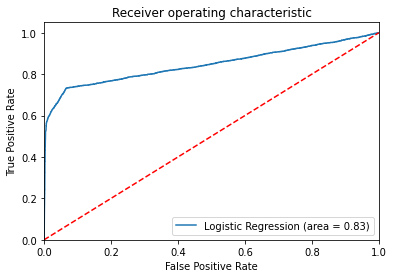

In [63]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [0]:
prob = logreg.predict_proba(X_test)[:,1]

In [0]:
def frange_positve(start, stop=None, step=None):
    if stop == None:
        stop = start + 0.0
        start = 0.0
    if step == None:
        step = 1.0
    print("start= ", start, "stop= ", stop, "step= ", step)

    count = 0
    while True:
        temp = float(start + count * step)
        if temp >= stop:
            break
        yield temp
        count += 1

In [0]:
from sklearn.metrics import f1_score

In [67]:
f1 = []
for i in frange_positve(0, 1, 0.001):
  pred = (prob>=i).astype(int)
  f1.append(f1_score(y_test,pred))

   

start=  0 stop=  1 step=  0.001


In [90]:
from sklearn.metrics import confusion_matrix

threshold = []
F1=[]
sen = []
spe = []

for i in frange_positve(0, 1, 0.001):
  threshold.append(i)
  pred = (prob>=i).astype(int)
  F1.append(f1_score(y_test,pred))
  tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
  specificity = tn / (tn+fp)
  sensitivity = tp / (tp+fn)
  sen.append(sensitivity)
  spe.append(specificity)




start=  0 stop=  1 step=  0.001


In [0]:
thre = pd.DataFrame()
thre['threshold'] = threshold
thre['F1'] = F1
thre['Sensitivity'] = sen
thre['Specificity'] = spe

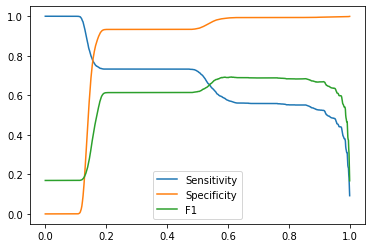

In [112]:
import matplotlib.pyplot as plt

plt.plot(threshold,sen,label = "Sensitivity")
plt.legend()
plt.plot(threshold,spe,label = "Specificity")
plt.legend()
plt.plot(threshold,F1,label = "F1")
plt.legend()

In [123]:
sen = np.array(sen)
spe = np.array(spe)
np.argwhere(np.diff(np.sign(spe - sen))).flatten()

array([155])

Found the treshhold with the highest recall value

In [124]:
threshold[155]

0.155

In [125]:
from sklearn.metrics import classification_report
pred = (prob>=0.155).astype(int)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.97      0.76      0.85     34286
           1       0.25      0.78      0.38      3492

    accuracy                           0.76     37778
   macro avg       0.61      0.77      0.62     37778
weighted avg       0.90      0.76      0.81     37778



In [71]:
logreg.coef_[0]

array([ 1.34675154e-02, -1.60765767e-02, -5.16908985e-03,  3.96983849e-09,
        1.97441779e+00, -1.38339317e+00, -5.24584231e-07, -6.91729233e-01,
       -4.81108819e-01, -6.90718604e-01, -8.42872419e-01, -8.49152956e-01,
       -8.80303655e-01, -8.04351093e-01, -8.17692414e-01, -1.21715499e-01,
       -8.31623700e-02])

In [74]:
X.columns

Index(['signup_weekofyear', 'purchase_weekofyear', 'age', 'signTOpurchase',
       'device_shared', 'ip_shared', 'country_shared', 'sourceAds',
       'sourceDirect', 'sourceSEO', 'browserChrome', 'browserFireFox',
       'browserIE', 'browserOpera', 'browserSafari', 'sexF', 'sexM'],
      dtype='object')

ERROR! Session/line number was not unique in database. History logging moved to new session 66


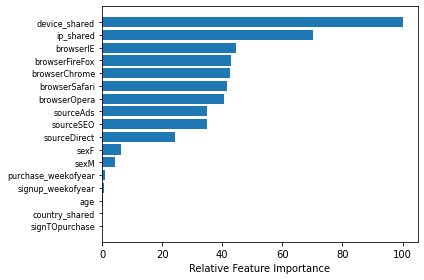

In [72]:
feature_importance = abs(logreg.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')
plt.tight_layout()   
plt.show()